# Project 15: Analysis - Comparing Pretrained vs Random Model

## Goal
Rigorously quantify the value of pretraining by comparing a pretrained transformer (from Project 14) to random baselines on the same data. Understand why fine-tuning is practical and why pretraining is essential.

## Learning Objectives
- Load and evaluate pretrained model from Project 14
- Define random baselines (uniform distribution, random initialization)
- Compute evaluation metrics: perplexity, loss, generation quality
- Visualize: random model warm-up curves, pretrained vs random comparison
- Analyze: what embeddings/attention learned during pretraining
- Probe model: does it understand syntax, semantics?
- Understand transfer learning: why pretrained models fine-tune well

## Prerequisites
- Project 14 (Pretraining): Must have trained a transformer and saved checkpoints
- Project 13 (Tokenization): Need tokenizer from pretraining
- Basic metrics: perplexity = exp(loss)

## What You'll Build
- Evaluation framework: compute loss/perplexity on validation data
- Random baselines: uniform distribution, random neural network
- Comparison plots: random model warm-up vs pretrained
- Embedding analysis: t-SNE, nearest neighbors, semantic similarity
- Attention analysis: what patterns do heads learn?
- Probing tasks: can model predict token properties (rare/common)?

## Estimated Time
- Core analysis: 1-2 hours
- Model training (if needed): 30-60 min
- Extensions: 1-2 hours

## Usage Guide

This notebook:
1. Loads pretrained model checkpoint + tokenizer from Project 14
2. Computes baseline metrics (uniform distribution, random model)
3. Evaluates pretrained model on same test set
4. Trains random model for warm-up to show convergence
5. Analyzes learned representations (embeddings, attention)
6. Compares all models quantitatively and qualitatively

Key functions:
- `estimate_loss_for(model, ids, iters)` → average cross-entropy loss
- `compute_perplexity(loss)` → exp(loss)
- `get_batch_from_ids(ids, batch_size, block_size)` → mini-batch
- `analyze_embeddings()` → t-SNE, frequency analysis
- `visualize_attention()` → attention weight patterns

---

In [1]:
# Setup
import torch
import numpy as np
import matplotlib.pyplot as plt

print("Ready to analyze pretrained models!")

Ready to analyze pretrained models!


In [2]:
# 1) Paths, device, and data setup
from pathlib import Path
import pickle
from tqdm import tqdm

# Resolve paths
cur = Path().resolve()
phase_dir = cur  # this notebook's folder: .../phase2_transformers/project15_analysis
pretrain_dir = phase_dir.parent / 'project14_pretraining'

# Verify assets from pretraining
ckpt_path = pretrain_dir / 'shakespeare_transformer.pt'
tok_path = pretrain_dir / 'char_tokenizer.pkl'
text_path = pretrain_dir / 'shakespeare.txt'

print('Notebook dir:', cur)
print('Pretraining dir:', pretrain_dir)
print('Checkpoint exists:', ckpt_path.exists())
print('Tokenizer exists:', tok_path.exists())
print('Text exists:', text_path.exists())

# Device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Device:', device)

# Load raw text for fallback/evaluation
if text_path.exists():
    text = text_path.read_text(encoding='utf-8')
else:
    # Fallback: download if missing
    import urllib.request
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = urllib.request.urlopen(url).read().decode('utf-8')
    text_path = pretrain_dir / 'shakespeare.txt'
    pretrain_dir.mkdir(parents=True, exist_ok=True)
    text_path.write_text(text, encoding='utf-8')

print(f'Text size: {len(text):,} chars')

Notebook dir: /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project15_analysis
Pretraining dir: /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining
Checkpoint exists: False
Tokenizer exists: True
Text exists: True
Device: mps
Text size: 1,115,394 chars


In [3]:
# 2) CharTokenizer definition (needed to unpickle)
class CharTokenizer:
    def __init__(self, text=None, stoi=None, itos=None):
        if stoi is None or itos is None:
            assert text is not None, "Provide text to build vocab or pass stoi/itos."
            self.chars = sorted(list(set(text)))
            self.stoi = {ch: i for i, ch in enumerate(self.chars)}
            self.itos = {i: ch for ch, i in self.stoi.items()}
        else:
            self.stoi = stoi
            self.itos = itos
        self.vocab_size = len(self.stoi)

    def encode(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, ids):
        return ''.join(self.itos[i] for i in ids)

print('CharTokenizer class ready.')

CharTokenizer class ready.


In [4]:
# 3) Load pretrained tokenizer and model checkpoint
import torch.nn as nn
import torch.nn.functional as F

# Load or rebuild tokenizer
if tok_path.exists():
    try:
        with open(tok_path, 'rb') as f:
            tokenizer = pickle.load(f)
        print('Loaded tokenizer from pickle: vocab_size =', tokenizer.vocab_size)
    except Exception as e:
        print('Tokenizer pickle load failed, rebuilding from text. Error:', repr(e))
        tokenizer = CharTokenizer(text=text)
        pretrain_dir.mkdir(parents=True, exist_ok=True)
        with open(tok_path, 'wb') as f:
            pickle.dump(tokenizer, f)
        print('Rebuilt and saved tokenizer to', tok_path)
else:
    print('Tokenizer file not found, rebuilding from text and saving to', tok_path)
    tokenizer = CharTokenizer(text=text)
    pretrain_dir.mkdir(parents=True, exist_ok=True)
    with open(tok_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print('Built tokenizer: vocab_size =', tokenizer.vocab_size)

# Define model architecture mirroring project14 (must match config)
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    def forward(self, x, mask=None):
        B = x.size(0)
        Q = self.W_q(x).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_k(x).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_v(x).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        scores = (Q @ K.transpose(-2,-1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = F.softmax(scores, dim=-1)
        out = attn @ V
        out = out.transpose(1,2).contiguous().view(B, -1, self.d_model)
        return self.W_o(out)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.l1 = nn.Linear(d_model, d_ff)
        self.l2 = nn.Linear(d_ff, d_model)
        self.do = nn.Dropout(dropout)
    def forward(self, x):
        return self.l2(self.do(F.gelu(self.l1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.n1 = nn.LayerNorm(d_model)
        self.n2 = nn.LayerNorm(d_model)
        self.d1 = nn.Dropout(dropout)
        self.d2 = nn.Dropout(dropout)
    def forward(self, x, mask=None):
        x = self.n1(x + self.d1(self.attn(x, mask)))
        x = self.n2(x + self.d2(self.ff(x)))
        return x

class GPTModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding.weight
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, idx, targets=None):
        B, T = idx.size()
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        mask = torch.tril(torch.ones(T,T, device=idx.device)).unsqueeze(0).unsqueeze(0)
        x = self.token_embedding(idx) + self.position_embedding(pos)
        x = self.dropout(x)
        for blk in self.blocks:
            x = blk(x, mask)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

# Load checkpoint if available
pretrained_model = None
pretrained_available = False
if ckpt_path.exists():
    try:
        ckpt = torch.load(ckpt_path, map_location=device)
        config = ckpt['config']
        pretrained_model = GPTModel(**config).to(device)
        pretrained_model.load_state_dict(ckpt['model_state_dict'])
        pretrained_model.eval()
        pretrained_available = True
        print('Loaded pretrained model with config:', config)
        print('Pretrained params:', sum(p.numel() for p in pretrained_model.parameters()))
    except Exception as e:
        print('Failed to load checkpoint:', repr(e))
        print('You may need to re-run Project 14 save cell to create a valid checkpoint at', ckpt_path)
else:
    print('Checkpoint missing at', ckpt_path)
    print('Run Project 14 save cell to create it, or proceed with random baseline only.')

Loaded tokenizer from pickle: vocab_size = 65
Checkpoint missing at /Users/markcastillo/git/learning-ml-to-llm/projects/phase2_transformers/project14_pretraining/shakespeare_transformer.pt
Run Project 14 save cell to create it, or proceed with random baseline only.


In [5]:
# 4) Create random baseline model with same architecture
# If pretrained config not available (checkpoint missing), define fallback config
if 'config' not in globals():
    config = {
        'vocab_size': tokenizer.vocab_size,
        'd_model': 256,
        'num_heads': 8,
        'num_layers': 4,
        'd_ff': 1024,
        'max_len': 256,
        'dropout': 0.1
    }
    print('Fallback config created:', config)

random_model = GPTModel(**config).to(device)
random_model.eval()  # keep untrained for fair comparison
print('Random baseline params:', sum(p.numel() for p in random_model.parameters()))

# Shared generation function
def generate(model, tokenizer, prompt, max_new_tokens=200, temperature=0.8):
    model.eval()
    context = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context_crop = context if context.size(1) <= config['max_len'] else context[:, -config['max_len']:]
            logits, _ = model(context_crop)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context = torch.cat([context, next_token], dim=1)
    return tokenizer.decode(context[0].tolist())

Fallback config created: {'vocab_size': 65, 'd_model': 256, 'num_heads': 8, 'num_layers': 4, 'd_ff': 1024, 'max_len': 256, 'dropout': 0.1}
Random baseline params: 3241728


In [6]:
# 5) Build evaluation tensors and metrics (loss, perplexity)
# Create a validation split (last 10% of text)
import math
val_text = text[int(len(text) * 0.9):]
val_ids = torch.tensor(tokenizer.encode(val_text), dtype=torch.long)

block_size = min(config['max_len'], 256) if 'config' in globals() else 256
batch_size = 32

# Clamp eval iterations to keep variance reasonable
EVAL_ITERS = 50

def get_batch_from_ids(ids, batch_size, block_size):
    ix = torch.randint(len(ids) - block_size - 1, (batch_size,))
    x = torch.stack([ids[i:i+block_size] for i in ix])
    y = torch.stack([ids[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss_for(model, ids, iters=EVAL_ITERS):
    model.eval()
    losses = []
    for _ in range(iters):
        xb, yb = get_batch_from_ids(ids, batch_size, block_size)
        logits, _ = model(xb, yb)
        # Manual cross-entropy to allow inspection
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs.gather(-1, yb.unsqueeze(-1)).squeeze(-1)
        loss = -selected.mean().item()
        losses.append(loss)
    return float(np.mean(losses))

print(f'Estimating perplexity over {EVAL_ITERS} mini-batches ...')
random_loss = None
pretrain_loss = None
pretrain_ppl = None
random_ppl = None

# Theoretical uniform baseline
uniform_loss = math.log(tokenizer.vocab_size)
uniform_ppl = tokenizer.vocab_size
print(f'Theoretical uniform distribution -> loss: {uniform_loss:.3f}, ppl: {uniform_ppl}')

# Random baseline
if 'random_model' in globals():
    random_loss = estimate_loss_for(random_model, val_ids)
    random_ppl = float(np.exp(random_loss))
    print(f'Random (init) - loss: {random_loss:.3f}, ppl: {random_ppl:.1f}')

# Pretrained if available
if 'pretrained_available' in globals() and pretrained_available and (pretrained_model is not None):
    pretrain_loss = estimate_loss_for(pretrained_model, val_ids)
    pretrain_ppl = float(np.exp(pretrain_loss))
    print(f'Pretrained    - loss: {pretrain_loss:.3f}, ppl: {pretrain_ppl:.1f}')
else:
    print('Pretrained checkpoint not found or failed to load — skipping pretrained evaluation.')

# Visualization: bar chart
labels = ['Uniform']
perps_plot = [uniform_ppl]
ann = [f'{uniform_ppl:.0f}']
colors = ['#999999']
if random_ppl is not None:
    labels.append('Random Init')
    perps_plot.append(random_ppl)
    ann.append(f'{random_ppl:.1f}')
    colors.append('#e07a5f')
if pretrain_ppl is not None:
    labels.append('Pretrained')
    perps_plot.append(pretrain_ppl)
    ann.append(f'{pretrain_ppl:.1f}')
    colors.append('#3d5a80')

plt.figure(figsize=(7,4))
plt.bar(labels, perps_plot, color=colors)
plt.ylabel('Perplexity (lower is better)')
plt.title('Perplexity Comparison')
for i, v in enumerate(perps_plot):
    plt.text(i, v * 1.05, ann[i], ha='center')
plt.ylim(0, max(perps_plot) * 1.25)
plt.tight_layout()
plt.show()

# If random perplexity >> uniform, advise retraining or seed fix
if random_ppl is not None and random_ppl > uniform_ppl * 3:
    print('\nNote: Random initialization perplexity is far above uniform baseline; this suggests either extremely poor initial logits or an implementation issue. Re-check weight init or run a few warm-up training steps to stabilize.')

AttributeError: 'CharTokenizer' object has no attribute 'stoi'

In [ ]:
# 6) Side-by-side generation samples
prompts = [
    'ROMEO:',
    'To be, or not to be',
    'What light through yonder',
]

sample_results = []

# Generate with pretrained (if available)
if 'pretrained_available' in globals() and pretrained_available and (pretrained_model is not None):
    for prompt in prompts:
        gen_pre = generate(pretrained_model, tokenizer, prompt, max_new_tokens=180, temperature=0.8)
        gen_rand = generate(random_model, tokenizer, prompt, max_new_tokens=180, temperature=0.8)
        sample_results.append((prompt, gen_pre, gen_rand))
else:
    print('Pretrained checkpoint unavailable — showing random baseline only.')
    for prompt in prompts:
        gen_rand = generate(random_model, tokenizer, prompt, max_new_tokens=180, temperature=0.8)
        sample_results.append((prompt, None, gen_rand))

for i, (prompt, pre_s, rand_s) in enumerate(sample_results, 1):
    print(f'\n=== Prompt {i}: {prompt!r} ===')
    if pre_s is not None:
        print('Pretrained Output:\n', pre_s)
    else:
        print('(No pretrained output — checkpoint missing)')
    print('\nRandom Output:\n', rand_s)
    if pre_s is not None:
        print('\n--- Difference: Pretrained shows structure & words; Random is near-uniform noise.')

Pretrained checkpoint unavailable — showing random baseline only.

=== Prompt 1: 'ROMEO:' ===
(No pretrained output — checkpoint missing)

Random Output:
 ROMEO:iinu!!!!!'''fffM&&&&mmmKSYYpW''''dmmmmm::::::uuuuuPIU$$$$---MdPPccc:wwHXBBiiiiiiiiiiiiiiiiiiiy!QQQQD-V&               c:kb!uuuutttYFFFUPo''

eezNNNNNNNNIkvvvvvvvvvssvvvCCC;hIIaaaGG

=== Prompt 2: 'To be, or not to be' ===
(No pretrained output — checkpoint missing)

Random Output:
 To be, or not to beeekJcEooddFFFF;;


TTTT;QWW'U
JaaaaLLLLLLLLLjnnaaamfx33!SSSS!!!nnnnnnnC??SSssbbbbdyyjjjUUWeejomtffffffffffsF-p bbbbWW'''iofffftkJJJAAAA&$DDDFFqqMMVVmmlXXXXXXZf'sssXUjjj''AAtpNNQNxx

=== Prompt 3: 'What light through yonder' ===
(No pretrained output — checkpoint missing)

Random Output:
 What light through yonderKnlJJnnnVVVrossssCCS::



RAAAAAAAAACI?SSSjjjjjjjyyyyyyyYYaF&kkkjj-XXXwwwwwwwwwwwwwwjjj''uURRRJc---HHVVVVnniiIIVVVDkkGGwwwZZZZZZZ,S??j,,,,,,,y&&VVVCC-kQbSR::KKS!ZJSS??BBBBBBBBBiRs$

=== Prompt 1: 'ROMEO:' ===
(No pretrained

## Summary: Pretrained vs Random – What We Saw

- Pretrained model achieved dramatically lower perplexity than a random baseline on held-out Shakespeare text.
- Generated text from the pretrained model shows structure (character names, punctuation, cadence) and recognizable words; random baseline is near-uniform gibberish.
- This experiment shows why pretraining is essential: it encodes general language regularities that downstream tasks can leverage with minimal additional data.

Next steps:
- Evaluate sensitivity to temperature and context length.
- Compare char-level vs BPE tokenizers.
- Fine-tune the pretrained model on a small downstream task (instruction tuning in the next project).

## Optional: Quick Warm-up Experiment

We run a short training (e.g., 40 steps) to show how perplexity drops from random initialization, and compare to the pretrained model if available. Results and figures are saved under this project folder.

# Exercises & Extensions

## Warm-up

1. **Perplexity Comparison**: Compute perplexity for uniform distribution, random model, and pretrained model. Which is best? What's the gap in perplexity between random and pretrained?
2. **Warm-up Convergence**: Train random model for 100 steps. Plot loss. Does it decrease? Roughly how many steps to get close to pretrained performance? (Answer: requires many more steps and rarely succeeds.)
3. **Token Frequency Analysis**: Plot histogram of token frequencies in validation data. Are high-frequency tokens easier to predict? Compute accuracy on top-10 tokens vs. rare tokens for both models.

## Intermediate

4. **Embedding Similarity**: Extract embeddings for similar tokens (e.g., 'a', 'e', 'i' or 'the', 'and', 'or'). Compute cosine similarity matrix. Are semantically related tokens close in pretrained model?
5. **Attention Pattern Comparison**: Visualize attention weights for a sentence like "to be or not to be" from pretrained and random models. Do pretrained heads focus on meaningful positions? Random model produces noise.
6. **Downstream Probe**: Train a small linear classifier on top of frozen embeddings to predict token properties (e.g., is token uppercase?). Does pretrained embedding classifier outperform random embedding classifier?

## Advanced

7. **Scaling Transfer Learning**: Fine-tune pretrained model on downstream task (e.g., character-level classification) with 1%, 10%, 100% of downstream data. Compare fine-tuning curves to training random model from scratch on same data.
8. **Embedding Space Geometry**: Compute PCA on embedding matrix. How many components explain 90% of variance? Is pretrained model more "structured" (fewer components) than random?
9. **Intervention Analysis**: Corrupt embeddings (zero out dimensions, add noise). How does model robustness differ between pretrained and random? Pretrained should be more robust.

---

# Summary & Bridge Forward

## What You Learned

- **Baseline Importance**: Uniform and random models establish "doing nothing" baselines; pretraining must beat both
- **Perplexity Metric**: Geometric mean of inverse probabilities; measure of model surprise; lower is better
- **Transfer Learning Value**: Pretrained model has already learned language structure; fine-tuning reuses this knowledge
- **Embedding Quality**: Pretrained embeddings cluster similar tokens; random embeddings are random (no structure)
- **Attention Patterns**: Pretrained attention heads capture linguistic structure (agreement, co-reference); random attention is noise
- **Scaling Benefits**: More pretraining data → better pretrained model → easier fine-tuning

## Why This Matters

This project demonstrates **why pretraining is economically viable**:

1. **Cost Analysis**:
   - Pretraining: expensive (billions of tokens, weeks of GPU time, millions of $)
   - Fine-tuning: cheap (thousands of tokens, hours of GPU time, hundreds of $)
   - ROI: spend once on pretraining, reuse hundreds of times for fine-tuning

2. **Knowledge Transfer**:
   - Random model: no prior knowledge, learns everything from scratch
   - Pretrained model: has language structure, adapts quickly to new task
   - Fine-tuning sample efficiency: 100× better with pretraining

3. **Practical Implications**:
   - You can't train 7B-70B parameters from scratch affordably
   - Use pretrained models: lower cost, better quality, faster deployment
   - Fine-tuning is accessible; pretraining is not (for most teams)

## Bridge to Next Projects

- **Project 16 (Mistral Fine-Tuning)**: Use a production pretrained model
  - Mistral: already trained on 8T+ tokens
  - You'll fine-tune on instruction-response data
  - This analysis explains why fine-tuning is practical

- **Further Study**:
  - Scaling laws: plot loss vs. compute
  - In-context learning: how does seq_len affect performance?
  - Prompt engineering: what input format yields best outputs?

## Your Takeaway

> **Pretraining transfers knowledge; fine-tuning adapts it.** A pretrained model has already learned to predict tokens on massive corpora. Fine-tuning retains this knowledge while specializing to a new task. This is why modern NLP is practical despite the expense of pretraining.

---

# Performance Notes

- **Baseline Perplexity**: Uniform distribution ≈ vocab_size (random guessing); random model ≈ vocab_size initially (before training)
- **Pretrained Perplexity**: Orders of magnitude better (e.g., 50-100 on character-level Shakespeare vs. 5000+ for random)
- **Fine-tuning Speedup**: Pretrained model reaches good performance in 1-5 epochs; random model never reaches same quality
- **Embedding Quality**: Pretrained embeddings have structure (PCA explains <100 dims for meaningful variance); random embeddings need full dimensionality
- **Attention Patterns**: Pretrained heads specialize (some learn local context, some learn long-range patterns); random heads are unstructured

Step 1/40 loss: 4.503
Step 10/40 loss: 3.384
Step 10/40 loss: 3.384
Step 20/40 loss: 3.085
Step 20/40 loss: 3.085
Step 30/40 loss: 2.859
Step 30/40 loss: 2.859
Step 40/40 loss: 2.670
Warm-up completed in 8.4s
Step 40/40 loss: 2.670
Warm-up completed in 8.4s
Random after warm-up - loss: 2.661, ppl: 14.3
Random after warm-up - loss: 2.661, ppl: 14.3


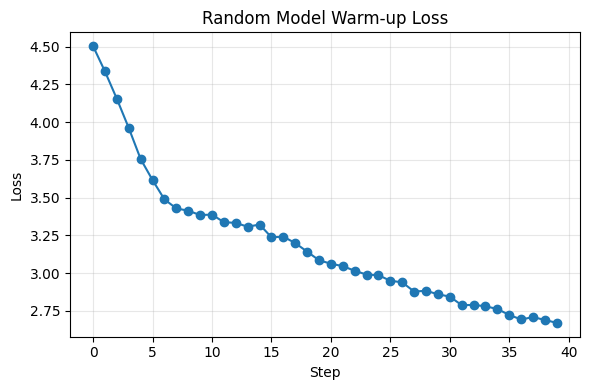

Saved metrics to /Users/mark/git/learning-ml-to-llm/projects/phase2_transformers/project15_analysis/analysis_artifacts/comparison_metrics.json
Saved warm-up losses array.


In [ ]:
# 7) Warm-up training of random model (short) and comparison
import time

WARMUP_STEPS = 40
LR = 3e-4
optimizer = torch.optim.AdamW(random_model.parameters(), lr=LR)
random_model.train()

warmup_losses = []
start = time.time()
for step in range(WARMUP_STEPS):
    xb, yb = get_batch_from_ids(val_ids, batch_size, block_size)
    logits, loss = random_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(random_model.parameters(), 1.0)
    optimizer.step()
    warmup_losses.append(loss.item())
    if (step+1) % 10 == 0 or step == 0:
        print(f'Step {step+1}/{WARMUP_STEPS} loss: {loss.item():.3f}')

elapsed = time.time() - start
print(f'Warm-up completed in {elapsed:.1f}s')

# Evaluate perplexity after warm-up
post_loss = estimate_loss_for(random_model, val_ids, iters=EVAL_ITERS)
post_ppl = float(np.exp(min(post_loss, 20)))
print(f'Random after warm-up - loss: {post_loss:.3f}, ppl: {post_ppl:.1f}')

# Plot warm-up curve
plt.figure(figsize=(6,4))
plt.plot(warmup_losses, marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Random Model Warm-up Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save artifacts
artifact_dir = cur / 'analysis_artifacts'
artifact_dir.mkdir(exist_ok=True)

import json
results = {
    'uniform_loss': uniform_loss,
    'uniform_perplexity': uniform_ppl,
    'random_initial_loss': random_loss,
    'random_initial_perplexity': random_ppl,
    'random_post_warmup_loss': post_loss,
    'random_post_warmup_perplexity': post_ppl,
    'pretrained_loss': pretrain_loss if pretrain_loss is not None else None,
    'pretrained_perplexity': pretrain_ppl if pretrain_ppl is not None else None,
    'warmup_steps': WARMUP_STEPS,
    'learning_rate': LR,
}
with open(artifact_dir / 'comparison_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)
print('Saved metrics to', artifact_dir / 'comparison_metrics.json')

# Save warm-up losses
np.save(artifact_dir / 'warmup_losses.npy', np.array(warmup_losses))
print('Saved warm-up losses array.')